In [24]:
using Pkg

In [25]:
Pkg.add("MAT")
Pkg.add("Glob")
Pkg.add("StatsBase")
Pkg.add("Random")
Pkg.add("MLDataUtils")
Pkg.add("Turing")
Pkg.add("Distributions")
Pkg.add("StatsPlots")
using MAT, Glob, StatsBase, Random, MLDataUtils, Turing, Distributions, StatsPlots

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.to

In [45]:
# sub-MOA101, sub-MOA102, sub-MOA104, sub-MOA105, sub-MOA107, sub-MOA108, sub-MOA109, sub-MOA110, sub-MOA111, sub-MOA112, sub-MOA114,
# sub-MOA115, sub-MOA116, sub-MOA118, sub-MOA121, sub-MOA122, sub-MOA123, sub-MOA124, sub-MOA126, sub-MOA127, sub-MOA128, sub-MOA130,
# sub-MOA131, sub-MOA133, sub-MOA134, sub-MOA135, sub-MOA301, sub-MOA302, sub-MOA303, sub-MOA304, sub-MOA305, sub-MOA306, sub-MOA307,
# sub-MOA309, sub-MOA312, sub-MOA314, sub-MOA315, sub-MOA317, sub-MOA319, sub-MOA320, sub-MOA321, sub-MOA325, sub-MOA327

y = (24, 22, 17, 34, 21, 41, 18, 29, 0, 5, 31, 22, 22, 5, 26, 37, 27, 36, 9, 20, 25, 29, 29, 32, 17, 37)

mean_y = mean(y)
var_y  = var(y)   # sample variance by default (divides by n-1)
std_y = sqrt(var_y)

10.514532068303591

In [46]:
# List of subjects that have some degree of depression
target_subjects = [
    "sub-MOA101", "sub-MOA102", "sub-MOA104", "sub-MOA105", "sub-MOA107", "sub-MOA108", "sub-MOA109", "sub-MOA110", "sub-MOA111",
    "sub-MOA112", "sub-MOA114", "sub-MOA115", "sub-MOA116", "sub-MOA118", "sub-MOA121", "sub-MOA122", "sub-MOA123","sub-MOA124", 
    "sub-MOA126", "sub-MOA127", "sub-MOA128", "sub-MOA130", "sub-MOA131", "sub-MOA133", "sub-MOA134", "sub-MOA135"]#"sub-MOA301", 
    #"sub-MOA302", "sub-MOA303", "sub-MOA304", "sub-MOA305", "sub-MOA306", "sub-MOA307", "sub-MOA309", "sub-MOA312","sub-MOA314", 
    #"sub-MOA315", "sub-MOA317", "sub-MOA319", "sub-MOA320", "sub-MOA321", "sub-MOA325", "sub-MOA327"]

# Base path to your subject folders
base_path = "Spectral_DCM_Collection_Model1"

# Collect valid file paths
valid_files = String[]

for subj in target_subjects
    subj_path = joinpath(base_path, subj)
    ses_path = joinpath(subj_path, "ses-b0")
    glm_path = joinpath(ses_path, "glm")
    dcm_file = joinpath(glm_path, "Spectral_DCM.mat")

    if !isdir(ses_path)
        @warn "Missing session folder: $ses_path"
    elseif !isfile(dcm_file)
        @warn "Missing Spectral_DCM.mat for $subj"
    else
        push!(valid_files, dcm_file)
    end
end

println("✅ Found Spectral_DCM.mat for $(length(valid_files)) out of $(length(target_subjects)) subjects.")


✅ Found Spectral_DCM.mat for 26 out of 26 subjects.


In [47]:
# Extract A matrix features (e.g., flatten full 4x4)
function extract_features(file)
    mat = matread(file)
    A = mat["DCM"]["Ep"]["A"]  # 4×4 matrix
    A = Matrix(A)              # Convert to regular Julia matrix if needed
    return [A[i, j] for i in 1:4, j in 1:4 if i != j]  # Exclude diagonal
end

extract_features (generic function with 1 method)

In [48]:
b0_MADRS = (35, 31, 41, 36, 38, 33, 25, 31, 30, 35, 37, 26, 34, 33, 25, 30, 30, 35, 24, 32, 33, 38, 28, 34, 35, 40)# 1, 0, 3, 6, 1, 1, 0, 1,
    #1, 0, 0, 1, 4, 1, 2, 0, 4)
# Create feature dataset
X = hcat([extract_features(file) for file in valid_files]...)'

# Convert b0_MADRS to a column vector
b0_vec = reshape(collect(b0_MADRS), :, 1)  # ensures it becomes a (n_subjects × 1) matrix

# Add it as the 13th feature (column) to X
X = hcat(X, b0_vec)

26×13 Matrix{Float64}:
 -0.183874    0.200038   -0.25122    …   0.157106     0.0534628  35.0
  0.23387     0.129208   -0.115115       0.0480798    0.150714   31.0
 -0.11233     0.280477    0.0251157      0.271268     0.190152   41.0
  0.107477    0.13921     0.176826       0.15949      0.160727   36.0
  0.084469    0.279525   -0.33087        0.115822     0.164236   38.0
  0.0581663   0.0835331   0.7367     …   0.00257609  -0.0742938  33.0
  0.0732204   0.189625    0.179149       0.0611454    0.194037   25.0
  0.039347    0.402827    0.274434       0.00906837  -0.0438798  31.0
  0.122882    0.390536   -0.130256       0.241984    -0.113679   30.0
  0.0909516   0.144003    0.153679       0.16696      0.175275   35.0
  0.141889   -0.109678    0.30434    …   0.221982    -0.0515337  37.0
  0.093902    0.349983   -0.440967       0.244651    -0.102102   26.0
  0.0291975   0.18549     0.155953       0.148456     0.199706   34.0
 -0.136576   -0.068967   -0.11182       -0.108216    -0.246995   33

In [49]:
@show size(X)        # should be (n_samples, n_features)
@show length(y)      # should be n_samples

# Assume: X is a matrix (n_samples × n_features), y is a vector (n_samples)
n_samples = size(X, 1)
idx = shuffle(1:n_samples)

# 80-20 split
n_train = round(Int, 0.8 * n_samples)
train_idx = idx[1:n_train]
test_idx  = idx[n_train+1:end]

# Create splits
X_train = X[train_idx, :]
y_train = y[train_idx]

X_test  = X[test_idx, :]
y_test  = y[test_idx]

size(X) = (26, 13)
length(y) = 26


(5, 37, 34, 37, 22)

In [50]:
using LinearAlgebra
Pkg.add("StatsFuns")
using StatsFuns

@model function bayesian_linear_regression(X, y)
    n, d = size(X)

    # Priors
    w ~ MvNormal(zeros(d), 1.0)     # weight prior
    b ~ Normal(0, 10)
    σ ~ Normal(0, 1)


    # Likelihood
    mu = X * w .+ b
    y ~ MvNormal(mu, σ)
end

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


bayesian_linear_regression (generic function with 2 methods)

In [51]:
X_train_std = (X_train .- mean(X_train, dims=1)) ./ std(X_train, dims=1)
y_train = collect(y_train)

X_test_std = (X_test .- mean(X_test, dims=1)) ./ std(X_test, dims=1)
y_test = collect(y_test)

5-element Vector{Int64}:
  5
 37
 34
 37
 22

In [52]:
Random.seed!(42)
model = bayesian_linear_regression(X_train_std, y_train)
chain = sample(model, NUTS(0.90), 100000; chains=4)

┌ Info: Found initial step size
└   ϵ = 0.003125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:08


Chains MCMC chain (100000×27×1 Array{Float64, 3}):

Iterations        = 1001:1:101000
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 8.65 seconds
Compute duration  = 8.65 seconds
parameters        = w[1], w[2], w[3], w[4], w[5], w[6], w[7], w[8], w[9], w[10], w[11], w[12], w[13], b, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse      ess_bulk     ess_tail      rha ⋯
      Symbol   Float64   Float64   Float64       Float64      Float64   Float6 ⋯

        w[1]   -0.0624    0.8639    0.0025   115342.2404   82551.2677    1.000 ⋯
        w[2]   -0.9740    0.8612    0.0025   121205.4748   82500.2531    1.000 ⋯
        w[3]    0.7017    0.8626    0.0025   121478.6119   82890.3856    1.000 ⋯
        w[4]   -0.0741    0.8632    0.0025   114976.3491   838

In [53]:
function predict_blr(chain, X_test_std)
    d = 13
    n_samples = length(chain[:b])
    n_test = size(X_test_std, 1)

    # Get weight matrix: (n_samples × d)
    w_matrix = hcat([chain[Symbol("w[$i]")] for i in 1:d]...)

    # Bias vector: (n_samples,)
    b_vec = chain[:b]

    # Predict: (n_test × n_samples)
    preds = X_test_std * w_matrix' .+ b_vec'  # Transpose bias to match rows

    # Posterior mean and std across samples
    y_mean = mean(preds, dims=2)
    y_std = std(preds, dims=2)
    return vec(y_mean), vec(y_std)
end

predict_blr (generic function with 1 method)

In [54]:
y_pred_mean, y_pred_std = predict_blr(chain, X_test_std)

([25.109090814870324, 21.39908176239959, 21.725162354027372, 23.972199535170382, 20.40578278942774], [3.423158142609596, 2.687850613335293, 2.4061894881455146, 2.1400377589016126, 3.04056765682429])

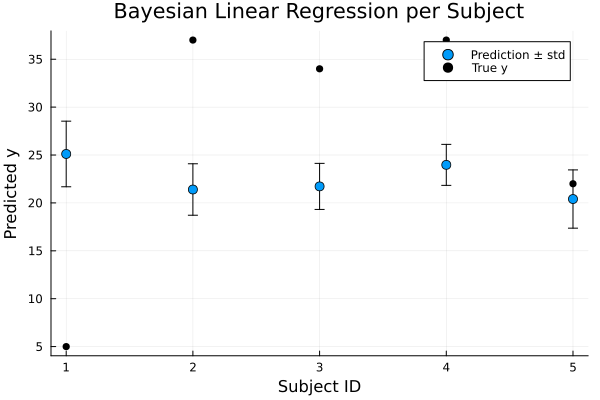

In [55]:
using Plots

n_subjects = length(y_pred_mean)
subject_ids = 1:n_subjects  # X-axis: Subject index (1 to 30)

scatter(
    subject_ids,
    collect(y_pred_mean),
    yerror=collect(y_pred_std),
    xlabel = "Subject ID",
    ylabel = "Predicted y",
    title = "Bayesian Linear Regression per Subject",
    label = "Prediction ± std",
    legend = :topright,
    markersize = 5
)
# Overlay true y values
scatter!(
    subject_ids,
    collect(y_test),
    label = "True y",
    color = :black,
    markersize = 4
)


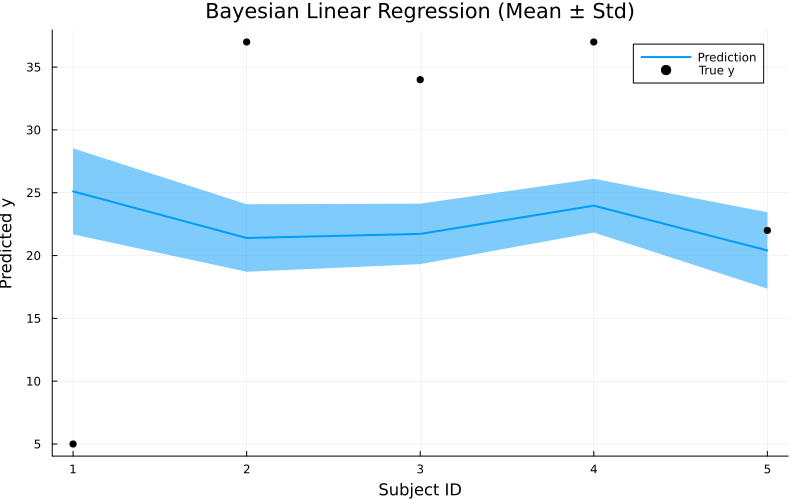

In [56]:
# Plot predicted mean with ± std ribbon
plot(
    subject_ids,
    collect(y_pred_mean),
    ribbon = collect(y_pred_std),
    xlabel = "Subject ID",
    ylabel = "Predicted y",
    title = "Bayesian Linear Regression (Mean ± Std)",
    label = "Prediction",
    linewidth = 2,
    legend = :topright,
    size = (800, 500)  # ⬅️ increased size for better y-axis resolution
)

# Overlay true y values
scatter!(
    subject_ids,
    collect(y_test),
    label = "True y",
    color = :black,
    markersize = 4
)

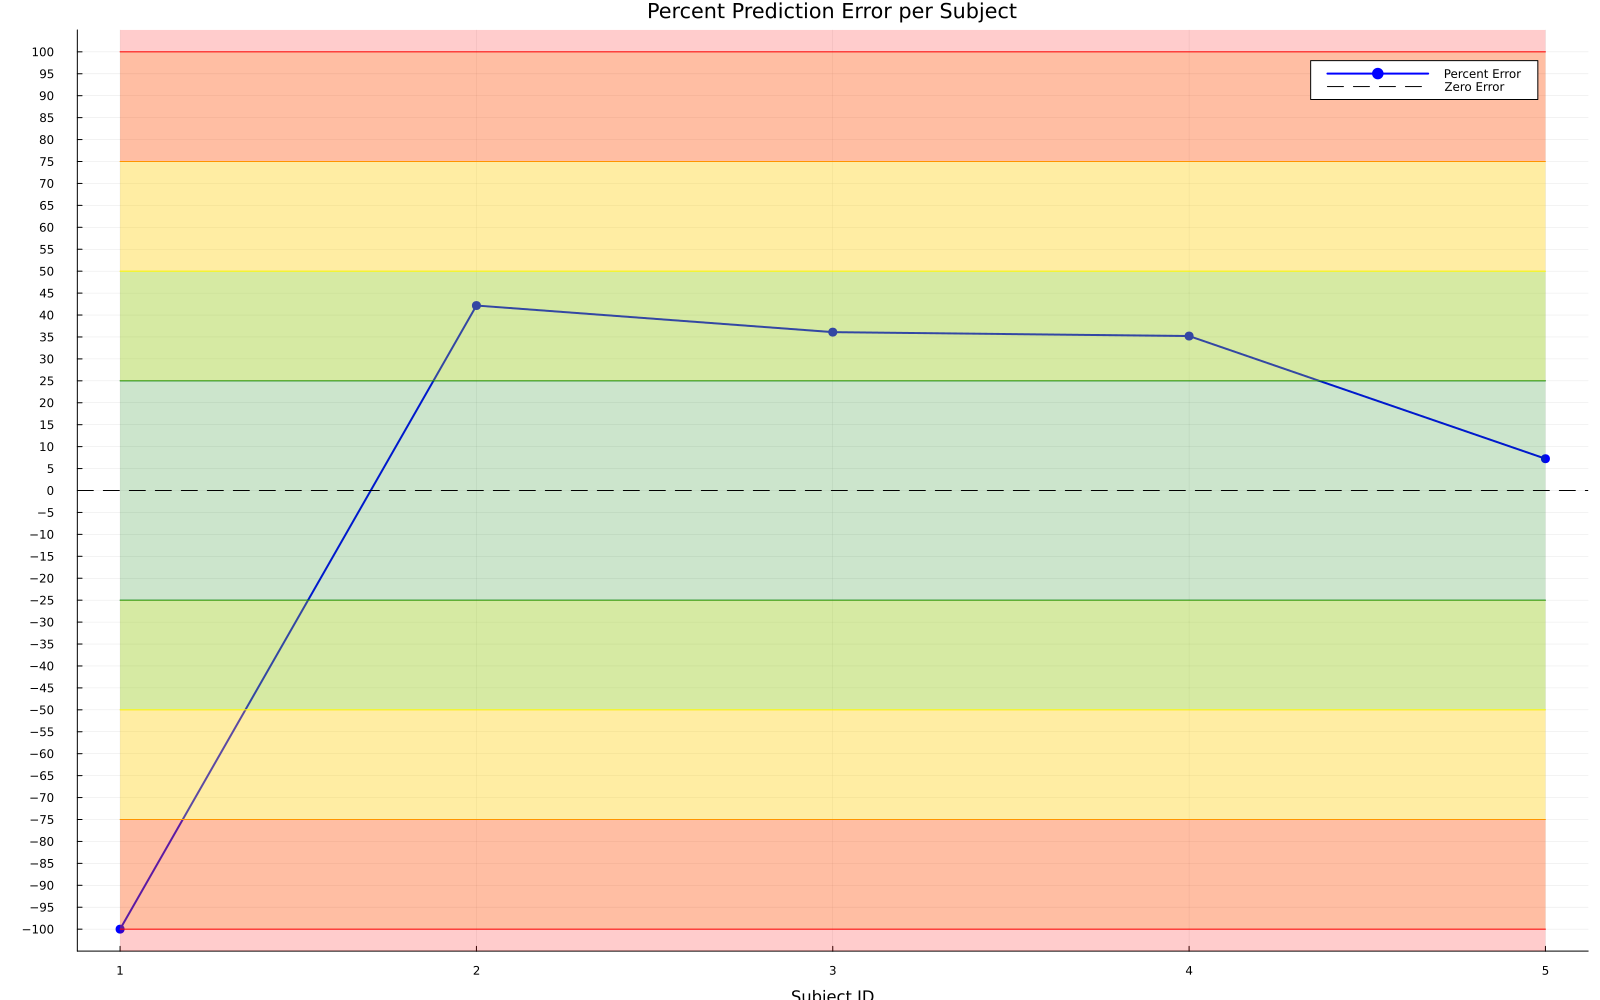

In [57]:
# Step 1: Calculate percent error and cap to ±100%
raw_errors = (collect(y_test) .- collect(y_pred_mean)) ./ (collect(y_test) .+ eps()) .* 100
residuals = clamp.(raw_errors, -100, 100)  # Cap to ±100%
subject_ids = 1:length(residuals)

# Step 2: Define band edges and matching colors
band_edges = [0, 25, 50, 75, 100]
band_colors = [:green, :yellow, :orange, :red, :purple]

# Step 3: Plot the percent error as a line with markers
plot(
    subject_ids,
    residuals,
    seriestype = :line,
    xlabel = "Subject ID",
    ylabel = "Percent Error (%)",
    title = "Percent Prediction Error per Subject",
    label = "Percent Error",
    legend = :topright,
    color = :blue,
    linewidth = 2,
    markershape = :circle,
    markersize = 5,
    markerstrokewidth = 0,
    size = (1600, 1000),
    ylim = (-105, 105),         # Ensure visibility for ±100% bands
    yticks = -100:5:100         # Y-axis ticks every 5%
)

# Step 4: Add symmetrical error bands
for i in 1:(length(band_edges)-1)
    lo, hi = band_edges[i], band_edges[i+1]
    color = band_colors[i]
    band_x = [1, length(residuals)]

    # Upper band
    plot!(
        band_x,
        fill(hi, 2),
        ribbon = fill(hi - lo, 2),
        fillalpha = 0.2,
        color = color,
        label = ""
    )

    # Lower mirrored band
    plot!(
        band_x,
        fill(-hi, 2),
        ribbon = fill(hi - lo, 2),
        fillalpha = 0.2,
        color = color,
        label = ""
    )
end

# Step 5: Add horizontal zero-error line
hline!([0], linestyle = :dash, color = :black, label = "Zero Error")

In [58]:
@model function bayesian_quadratic_model(X, y)
    n, d = size(X)

    # Linear and quadratic weights
    w       ~ MvNormal(zeros(d), 1.0)      # linear
    w_quad  ~ MvNormal(zeros(d), 1.0)      # quadratic
    b       ~ Normal(0, 10)
    σ       ~ truncated(Normal(0, 1), 0, Inf)

    for i in 1:n
        x_i = X[i, :]
        x2_i = x_i .^ 2  # elementwise square
        mu = dot(w, x_i) + dot(w_quad, x2_i) + b
        y[i] ~ Normal(mu, σ)
    end
end

bayesian_quadratic_model (generic function with 2 methods)

In [59]:
model = bayesian_quadratic_model(X_train_std, y_train)
chain = sample(model, NUTS(0.90), 10000)

┌ Info: Found initial step size
└   ϵ = 0.003125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03


Chains MCMC chain (10000×40×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 4.26 seconds
Compute duration  = 4.26 seconds
parameters        = w[1], w[2], w[3], w[4], w[5], w[6], w[7], w[8], w[9], w[10], w[11], w[12], w[13], w_quad[1], w_quad[2], w_quad[3], w_quad[4], w_quad[5], w_quad[6], w_quad[7], w_quad[8], w_quad[9], w_quad[10], w_quad[11], w_quad[12], w_quad[13], b, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse     ess_bulk    ess_tail      rhat  ⋯
      Symbol   Float64   Float64   Float64      Float64     Float64   Float64  ⋯

        w[1]   -0.1472    0.9083    0.0063   20523.4699   7787.7180    1.0000  ⋯
        w[2]   -0.5675    0.9048    0.0063   20325.2160   7058.4519    1.0000  ⋯

In [60]:
function predict_quadratic(chain, X)
    d = size(X, 2)
    n_samples = length(chain[:b])
    n_test = size(X, 1)

    # Extract weights: shape (n_samples, d)
    w      = hcat([chain[Symbol("w[$i]")] for i in 1:d]...)
    w_quad = hcat([chain[Symbol("w_quad[$i]")] for i in 1:d]...)
    b      = chain[:b]

    preds = zeros(n_test, n_samples)
    for i in 1:n_samples
        ŷ = X * w[i, :] .+ X.^2 * w_quad[i, :] .+ b[i]  # ✅ fixed dot products
        preds[:, i] = ŷ
    end

    y_mean = mean(preds, dims=2)
    y_std = std(preds, dims=2)
    return vec(y_mean), vec(y_std)
end


predict_quadratic (generic function with 1 method)

In [61]:
y_pred_mean, y_pred_std = predict_quadratic(chain, X_test_std)


([24.030773461598102, 20.33661502808511, 21.34909702788286, 22.54905148751835, 21.189273752879146], [3.92193615516225, 3.167670073545301, 2.6370758159424077, 2.8467145519165595, 3.665626169363282])

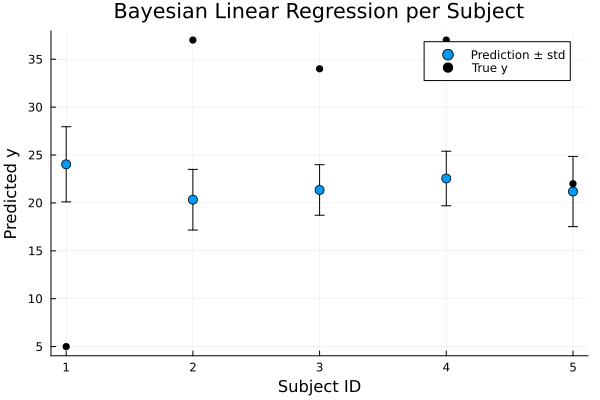

In [62]:
scatter(
    subject_ids,
    collect(y_pred_mean),
    yerror=collect(y_pred_std),
    xlabel = "Subject ID",
    ylabel = "Predicted y",
    title = "Bayesian Linear Regression per Subject",
    label = "Prediction ± std",
    legend = :topright,
    markersize = 5
)
# Overlay true y values
scatter!(
    subject_ids,
    collect(y_test),
    label = "True y",
    color = :black,
    markersize = 4
)

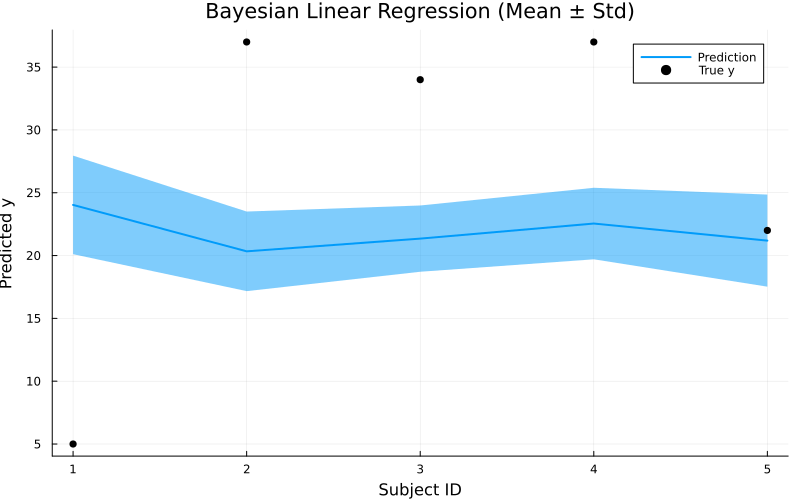

In [63]:
# Plot predicted mean with ± std ribbon
plot(
    subject_ids,
    collect(y_pred_mean),
    ribbon = collect(y_pred_std),
    xlabel = "Subject ID",
    ylabel = "Predicted y",
    title = "Bayesian Linear Regression (Mean ± Std)",
    label = "Prediction",
    linewidth = 2,
    legend = :topright,
    size = (800, 500)  # ⬅️ increased size for better y-axis resolution
)

# Overlay true y values
scatter!(
    subject_ids,
    collect(y_test),
    label = "True y",
    color = :black,
    markersize = 4
)

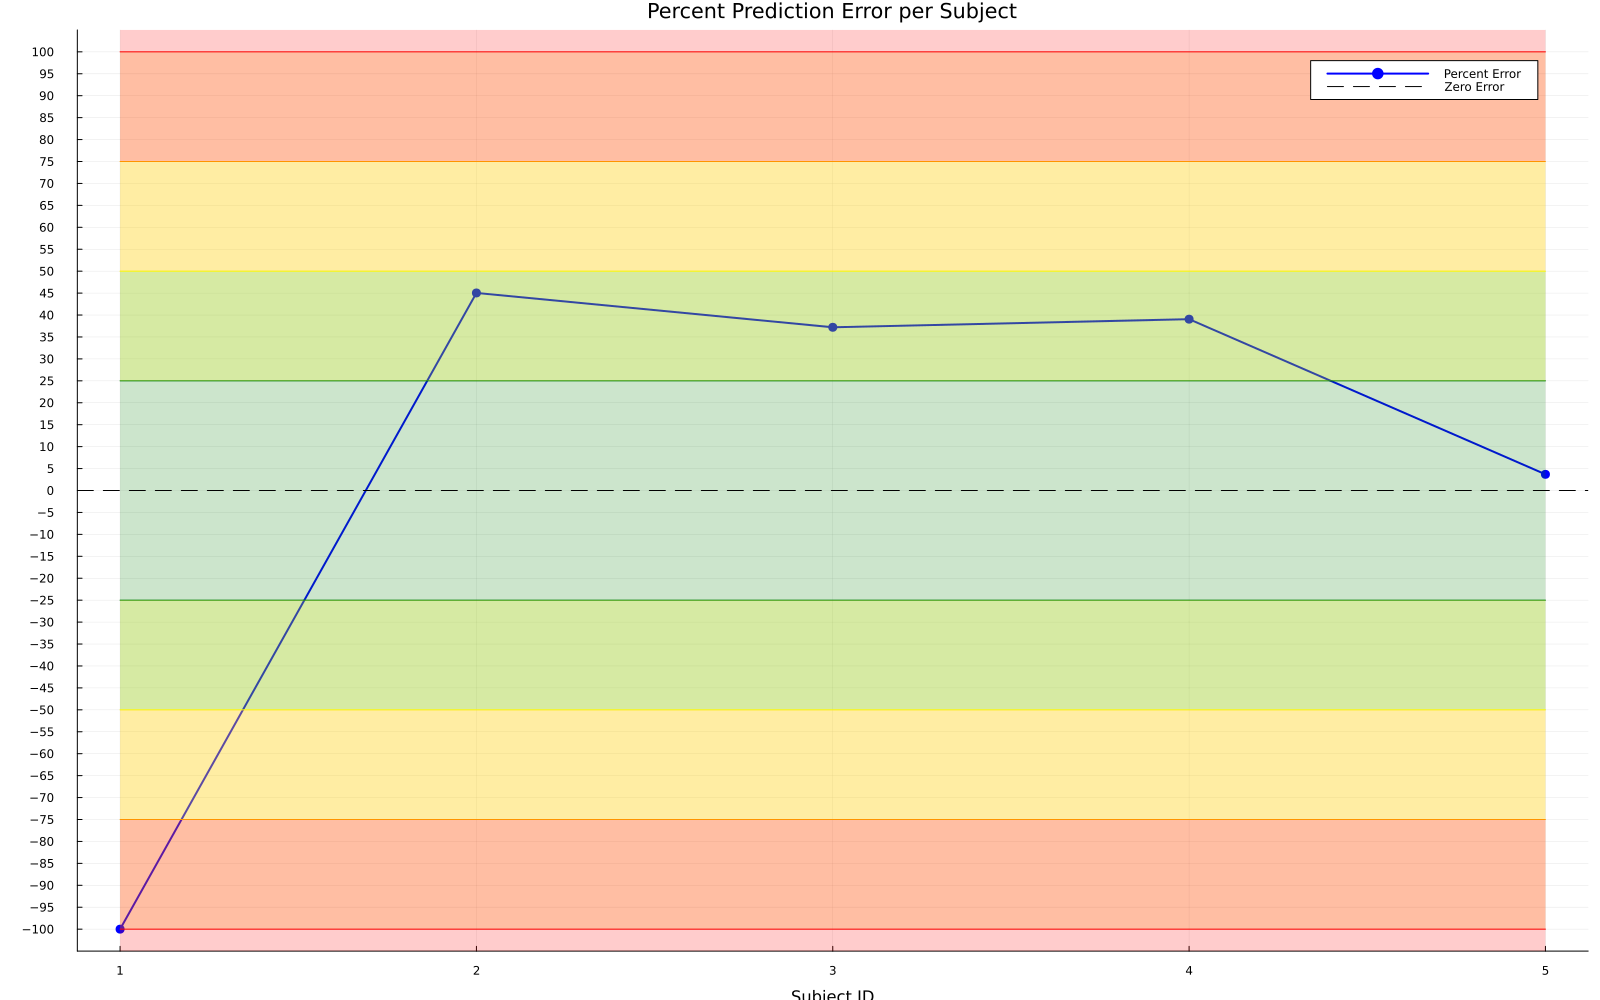

In [64]:
# Step 1: Calculate percent error and cap to ±100%
raw_errors = (collect(y_test) .- collect(y_pred_mean)) ./ (collect(y_test) .+ eps()) .* 100
residuals = clamp.(raw_errors, -100, 100)  # Cap to ±100%
subject_ids = 1:length(residuals)

# Step 2: Define band edges and matching colors
band_edges = [0, 25, 50, 75, 100]
band_colors = [:green, :yellow, :orange, :red, :purple]

# Step 3: Plot the percent error as a line with markers
plot(
    subject_ids,
    residuals,
    seriestype = :line,
    xlabel = "Subject ID",
    ylabel = "Percent Error (%)",
    title = "Percent Prediction Error per Subject",
    label = "Percent Error",
    legend = :topright,
    color = :blue,
    linewidth = 2,
    markershape = :circle,
    markersize = 5,
    markerstrokewidth = 0,
    size = (1600, 1000),
    ylim = (-105, 105),         # Ensure visibility for ±100% bands
    yticks = -100:5:100         # Y-axis ticks every 5%
)

# Step 4: Add symmetrical error bands
for i in 1:(length(band_edges)-1)
    lo, hi = band_edges[i], band_edges[i+1]
    color = band_colors[i]
    band_x = [1, length(residuals)]

    # Upper band
    plot!(
        band_x,
        fill(hi, 2),
        ribbon = fill(hi - lo, 2),
        fillalpha = 0.2,
        color = color,
        label = ""
    )

    # Lower mirrored band
    plot!(
        band_x,
        fill(-hi, 2),
        ribbon = fill(hi - lo, 2),
        fillalpha = 0.2,
        color = color,
        label = ""
    )
end

# Step 5: Add horizontal zero-error line
hline!([0], linestyle = :dash, color = :black, label = "Zero Error")

In [65]:
@model function bayesian_cubic_model(X, y)
    n, d = size(X)

    # Priors for linear, quadratic, cubic terms
    w       ~ MvNormal(zeros(d), 1.0)       # linear
    w_quad  ~ MvNormal(zeros(d), 1.0)       # quadratic
    w_cubic ~ MvNormal(zeros(d), 1.0)       # cubic
    b       ~ Normal(0, 10)
    σ       ~ truncated(Normal(0, 1), 0, Inf)

    for i in 1:n
        x_i = X[i, :]
        mu = dot(w, x_i) +
             dot(w_quad, x_i .^ 2) +
             dot(w_cubic, x_i .^ 3) + b
        y[i] ~ Normal(mu, σ)
    end
end

bayesian_cubic_model (generic function with 2 methods)

In [66]:
model = bayesian_cubic_model(X_train_std, y_train)
chain = sample(model, NUTS(0.9), 10000)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:09


Chains MCMC chain (10000×53×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 11.73 seconds
Compute duration  = 11.73 seconds
parameters        = w[1], w[2], w[3], w[4], w[5], w[6], w[7], w[8], w[9], w[10], w[11], w[12], w[13], w_quad[1], w_quad[2], w_quad[3], w_quad[4], w_quad[5], w_quad[6], w_quad[7], w_quad[8], w_quad[9], w_quad[10], w_quad[11], w_quad[12], w_quad[13], w_cubic[1], w_cubic[2], w_cubic[3], w_cubic[4], w_cubic[5], w_cubic[6], w_cubic[7], w_cubic[8], w_cubic[9], w_cubic[10], w_cubic[11], w_cubic[12], w_cubic[13], b, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse     ess_bulk    ess_tail      rhat  ⋯
      Symbol   Float64   Float64   Float64      Float64     Float64   Float64  ⋯


In [67]:
function predict_cubic(chain, X)
    d = size(X, 2)
    n_samples = length(chain[:b])
    n_test = size(X, 1)

    w       = hcat([chain[Symbol("w[$i]")] for i in 1:d]...)
    w_quad  = hcat([chain[Symbol("w_quad[$i]")] for i in 1:d]...)
    w_cubic = hcat([chain[Symbol("w_cubic[$i]")] for i in 1:d]...)
    b       = chain[:b]

    preds = zeros(n_test, n_samples)
    for i in 1:n_samples
        ŷ = X * w[i, :] .+
             (X .^ 2) * w_quad[i, :] .+
             (X .^ 3) * w_cubic[i, :] .+
             b[i]
        preds[:, i] = ŷ
    end

    y_mean = mean(preds, dims=2)
    y_std  = std(preds, dims=2)
    return vec(y_mean), vec(y_std)
end

predict_cubic (generic function with 1 method)

In [68]:
y_pred_mean, y_pred_std = predict_cubic(chain, X_test_std)

([19.949264647205528, 18.96026555567208, 21.436673802704192, 23.790504882201922, 25.377887101375475], [4.096902346884626, 3.4521161411482937, 2.5386507157678357, 3.207291280535923, 5.614644210327809])

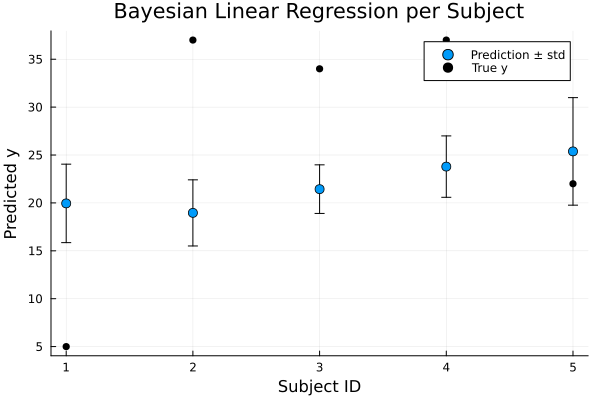

In [69]:
scatter(
    subject_ids,
    collect(y_pred_mean),
    yerror=collect(y_pred_std),
    xlabel = "Subject ID",
    ylabel = "Predicted y",
    title = "Bayesian Linear Regression per Subject",
    label = "Prediction ± std",
    legend = :topright,
    markersize = 5
)
# Overlay true y values
scatter!(
    subject_ids,
    collect(y_test),
    label = "True y",
    color = :black,
    markersize = 4
)

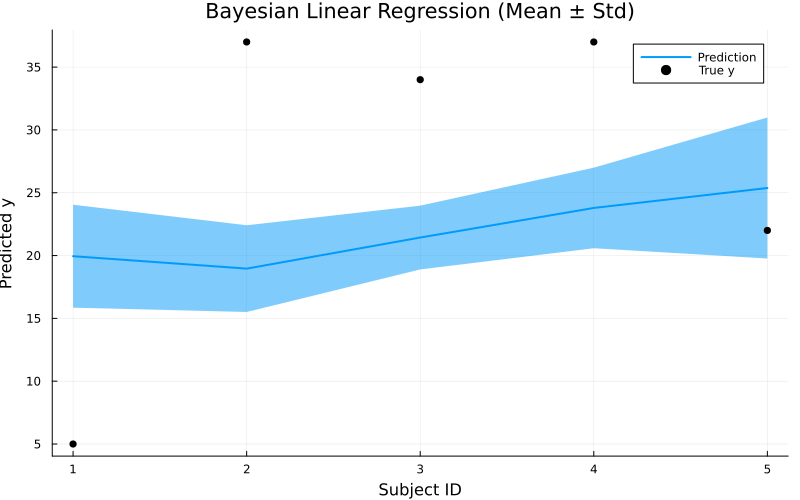

In [70]:
# Plot predicted mean with ± std ribbon
plot(
    subject_ids,
    collect(y_pred_mean),
    ribbon = collect(y_pred_std),
    xlabel = "Subject ID",
    ylabel = "Predicted y",
    title = "Bayesian Linear Regression (Mean ± Std)",
    label = "Prediction",
    linewidth = 2,
    legend = :topright,
    size = (800, 500)  # ⬅️ increased size for better y-axis resolution
)

# Overlay true y values
scatter!(
    subject_ids,
    collect(y_test),
    label = "True y",
    color = :black,
    markersize = 4
)

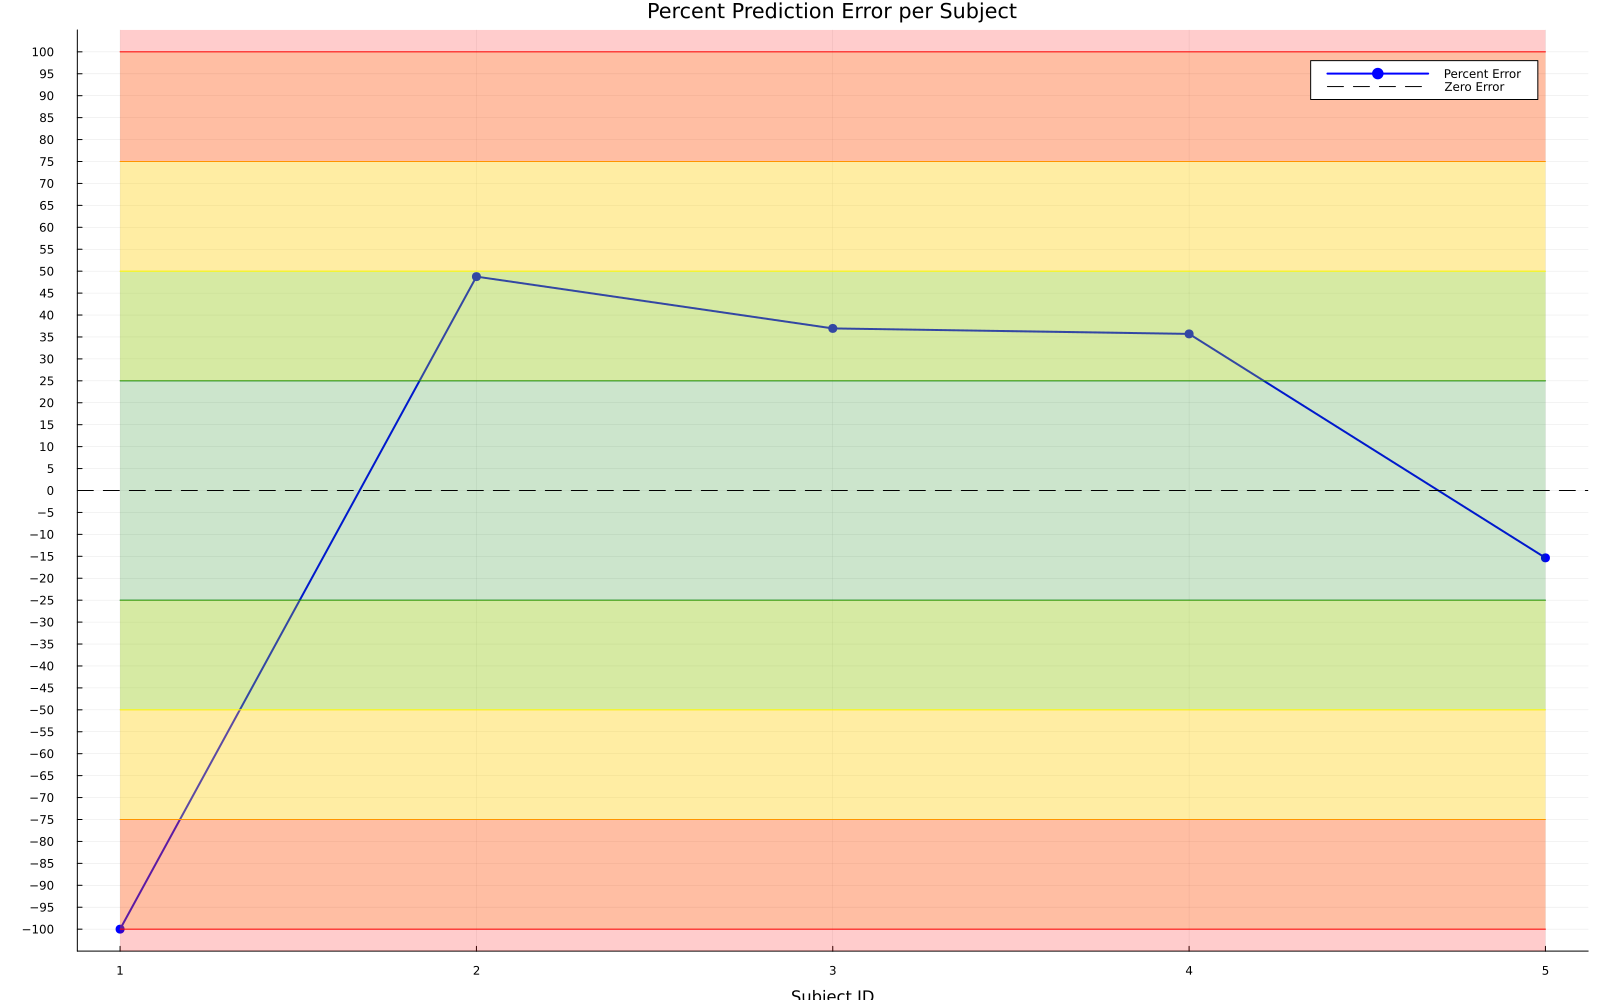

In [71]:
# Step 1: Calculate percent error and cap to ±100%
raw_errors = (collect(y_test) .- collect(y_pred_mean)) ./ (collect(y_test) .+ eps()) .* 100
residuals = clamp.(raw_errors, -100, 100)  # Cap to ±100%
subject_ids = 1:length(residuals)

# Step 2: Define band edges and matching colors
band_edges = [0, 25, 50, 75, 100]
band_colors = [:green, :yellow, :orange, :red, :purple]

# Step 3: Plot the percent error as a line with markers
plot(
    subject_ids,
    residuals,
    seriestype = :line,
    xlabel = "Subject ID",
    ylabel = "Percent Error (%)",
    title = "Percent Prediction Error per Subject",
    label = "Percent Error",
    legend = :topright,
    color = :blue,
    linewidth = 2,
    markershape = :circle,
    markersize = 5,
    markerstrokewidth = 0,
    size = (1600, 1000),
    ylim = (-105, 105),         # Ensure visibility for ±100% bands
    yticks = -100:5:100         # Y-axis ticks every 5%
)

# Step 4: Add symmetrical error bands
for i in 1:(length(band_edges)-1)
    lo, hi = band_edges[i], band_edges[i+1]
    color = band_colors[i]
    band_x = [1, length(residuals)]

    # Upper band
    plot!(
        band_x,
        fill(hi, 2),
        ribbon = fill(hi - lo, 2),
        fillalpha = 0.2,
        color = color,
        label = ""
    )

    # Lower mirrored band
    plot!(
        band_x,
        fill(-hi, 2),
        ribbon = fill(hi - lo, 2),
        fillalpha = 0.2,
        color = color,
        label = ""
    )
end

# Step 5: Add horizontal zero-error line
hline!([0], linestyle = :dash, color = :black, label = "Zero Error")

In [73]:
mean_model_var = mean(y_pred_std .^ 2)
println("Global variance in y: ", var_y)
println("Average predictive variance: ", mean_model_var)

mean_model_std = mean(y_pred_std)
println("Global std dev in y: ", std_y)
println("Average predictive std dev: ", mean_model_std)

median_model_var = median(y_pred_std .^ 2)
println("Median Global variance in y: ", median(var_y))
println("Median predictive variance: ", median_model_var)

median_model_std = median(y_pred_std)
println("Median Global std dev in y: ", median(std_y))
println("Median predictive std dev: ", median_model_std)

Global variance in y: 110.5553846153846
Average predictive variance: 15.391481823064646
Global std dev in y: 10.514532068303591
Average predictive std dev: 3.7819209389328976
Median Global variance in y: 110.5553846153846
Median predictive variance: 11.917105851976586
Median Global std dev in y: 10.514532068303591
Median predictive std dev: 3.4521161411482937


In [74]:
@model function bayesian_polynomial_model(X, y, p::Int)
    n, d = size(X)

    # Explicitly declare each weights[k] ~ MvNormal
    weights = Vector{Vector{Real}}(undef, p)
    for k in 1:p
        weights[k] ~ MvNormal(zeros(d), 1.0)
    end

    b ~ Normal(0, 10)
    σ ~ truncated(Normal(0, 1), 0, Inf)

    for i in 1:n
        x_i = X[i, :]
        mu = b
        for k in 1:p
            mu += dot(weights[k], x_i .^ k)
        end
        y[i] ~ Normal(mu, σ)
    end
end

bayesian_polynomial_model (generic function with 2 methods)

In [75]:
p = 4  # 4th order
model = bayesian_polynomial_model(X_train_std, y_train, p)
chain = sample(model, NUTS(0.9), 1000)

┌ Info: Found initial step size
└   ϵ = 0.025
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:09


Chains MCMC chain (1000×66×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 10.5 seconds
Compute duration  = 10.5 seconds
parameters        = weights[1][1], weights[1][2], weights[1][3], weights[1][4], weights[1][5], weights[1][6], weights[1][7], weights[1][8], weights[1][9], weights[1][10], weights[1][11], weights[1][12], weights[1][13], weights[2][1], weights[2][2], weights[2][3], weights[2][4], weights[2][5], weights[2][6], weights[2][7], weights[2][8], weights[2][9], weights[2][10], weights[2][11], weights[2][12], weights[2][13], weights[3][1], weights[3][2], weights[3][3], weights[3][4], weights[3][5], weights[3][6], weights[3][7], weights[3][8], weights[3][9], weights[3][10], weights[3][11], weights[3][12], weights[3][13], weights[4][1], weights[4][2], weights[4][3], weights[4][4], weights[4][5], weights[4][6], weights[4][7], weights[4][8], weights[4][9], weights[4][10], weights[4][11], weights[4][12], weight

In [76]:
function predict_polynomial(chain, X, p::Int)
    d = size(X, 2)
    n_samples = length(chain[:b])
    n_test = size(X, 1)
    preds = zeros(n_test, n_samples)

    for i in 1:n_samples
        mu = zeros(n_test)
        for k in 1:p
            w_k = hcat([chain[Symbol("weights[$k][$j]")] for j in 1:d]...)
            mu .+= (X .^ k) * w_k[i, :]
        end
        mu .+= chain[:b][i]
        preds[:, i] = mu
    end

    y_mean = mean(preds, dims=2)
    y_std = std(preds, dims=2)
    return vec(y_mean), vec(y_std)
end

predict_polynomial (generic function with 1 method)

In [77]:
y_pred_mean, y_pred_std = predict_polynomial(chain, X_test_std, 4)

([14.938994031191152, 23.674408522675577, 21.501704703829862, 22.486056507503633, 25.229845918189746], [5.313959485920064, 4.670353449050715, 2.875214530878194, 3.9859251751052907, 6.277135735148301])

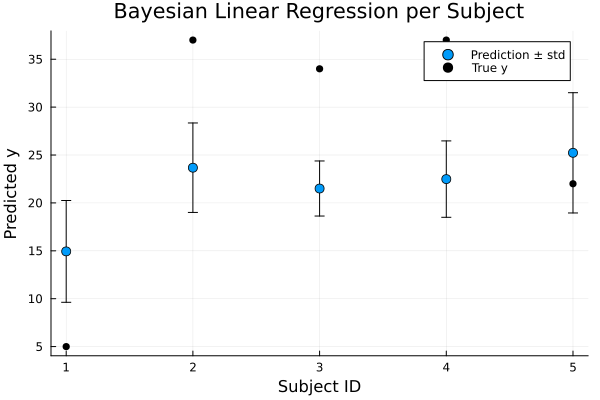

In [78]:
scatter(
    subject_ids,
    collect(y_pred_mean),
    yerror=collect(y_pred_std),
    xlabel = "Subject ID",
    ylabel = "Predicted y",
    title = "Bayesian Linear Regression per Subject",
    label = "Prediction ± std",
    legend = :topright,
    markersize = 5
)

# Overlay true y values
scatter!(
    subject_ids,
    collect(y_test),
    label = "True y",
    color = :black,
    markersize = 4
)

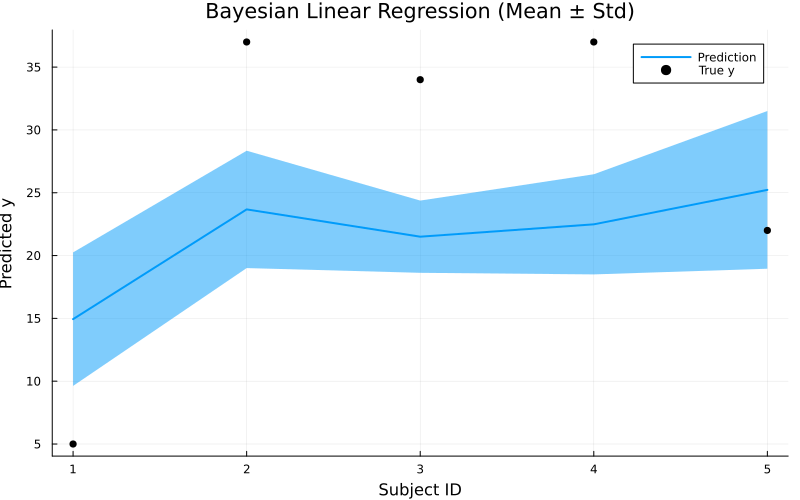

In [79]:
# Plot predicted mean with ± std ribbon
plot(
    subject_ids,
    collect(y_pred_mean),
    ribbon = collect(y_pred_std),
    xlabel = "Subject ID",
    ylabel = "Predicted y",
    title = "Bayesian Linear Regression (Mean ± Std)",
    label = "Prediction",
    linewidth = 2,
    legend = :topright,
    size = (800, 500)  # ⬅️ increased size for better y-axis resolution
)

# Overlay true y values
scatter!(
    subject_ids,
    collect(y_test),
    label = "True y",
    color = :black,
    markersize = 4
)

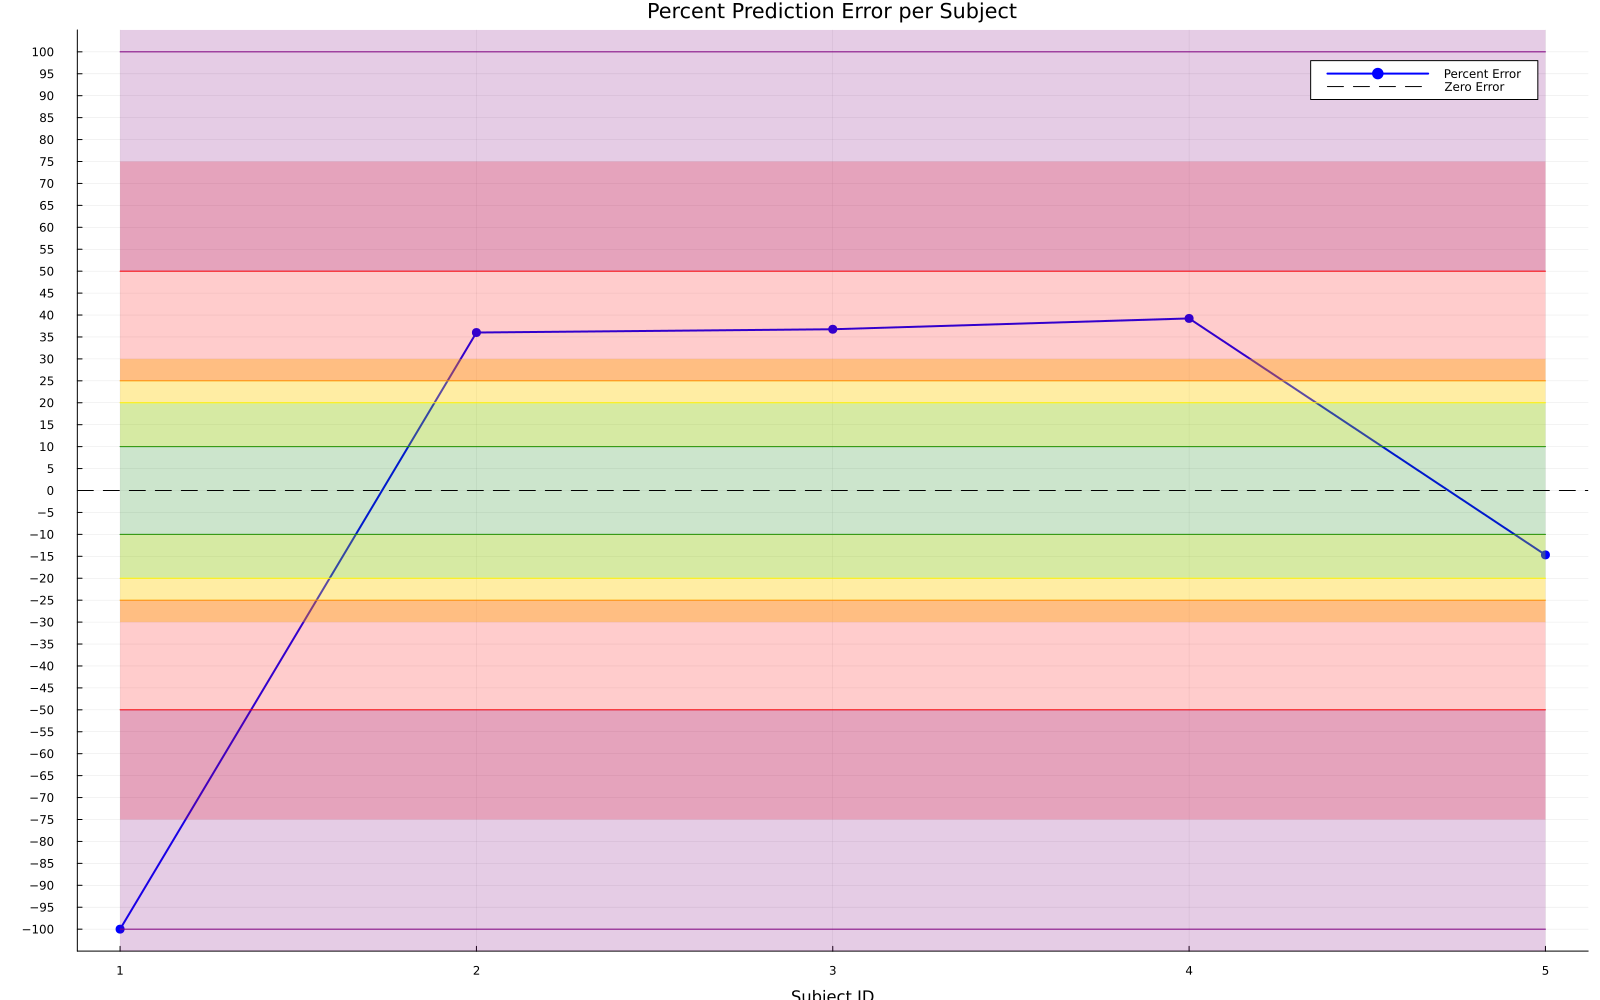

In [80]:
# Step 1: Calculate percent error and cap to ±100%
raw_errors = (collect(y_test) .- collect(y_pred_mean)) ./ (collect(y_test) .+ eps()) .* 100
residuals = clamp.(raw_errors, -100, 100)  # Cap to ±100%
subject_ids = 1:length(residuals)

# Step 2: Define band edges and matching colors
band_edges = [0, 10, 20, 25, 50, 100]
band_colors = [:green, :yellow, :orange, :red, :purple, :brown]

# Step 3: Plot the percent error as a line with markers
plot(
    subject_ids,
    residuals,
    seriestype = :line,
    xlabel = "Subject ID",
    ylabel = "Percent Error (%)",
    title = "Percent Prediction Error per Subject",
    label = "Percent Error",
    legend = :topright,
    color = :blue,
    linewidth = 2,
    markershape = :circle,
    markersize = 5,
    markerstrokewidth = 0,
    size = (1600, 1000),
    ylim = (-105, 105),         # Ensure visibility for ±100% bands
    yticks = -100:5:100         # Y-axis ticks every 5%
)

# Step 4: Add symmetrical error bands
for i in 1:(length(band_edges)-1)
    lo, hi = band_edges[i], band_edges[i+1]
    color = band_colors[i]
    band_x = [1, length(residuals)]

    # Upper band
    plot!(
        band_x,
        fill(hi, 2),
        ribbon = fill(hi - lo, 2),
        fillalpha = 0.2,
        color = color,
        label = ""
    )

    # Lower mirrored band
    plot!(
        band_x,
        fill(-hi, 2),
        ribbon = fill(hi - lo, 2),
        fillalpha = 0.2,
        color = color,
        label = ""
    )
end

# Step 5: Add horizontal zero-error line
hline!([0], linestyle = :dash, color = :black, label = "Zero Error")

In [81]:
function k_fold_indices(n, k=5)
    indices = shuffle(1:n)
    fold_size = cld(n, k)
    return [indices[((i-1)*fold_size+1):min(i*fold_size, n)] for i in 1:k]
end

k_fold_indices (generic function with 2 methods)

In [82]:
function cross_validate_poly(X, y; k=5, p, num_samples)
    n = size(X, 1)
    folds = k_fold_indices(n, k)
    rmse_scores = Float64[]

    for i in 1:k
        test_idx = folds[i]
        train_idx = setdiff(1:n, test_idx)

        X_train, y_train = X[train_idx, :], y[train_idx]
        X_test,  y_test  = X[test_idx, :],  y[test_idx]

        model = bayesian_polynomial_model(X_train, y_train, p)
        chain = sample(model, NUTS(0.8), num_samples)

        y_pred_mean, _ = predict_polynomial(chain, X_test, p)
        rmse = sqrt(mean((y_test .- y_pred_mean).^2))
        push!(rmse_scores, rmse)
    end

    return mean(rmse_scores), std(rmse_scores)
end

cross_validate_poly (generic function with 1 method)

In [83]:
mean_rmse, std_rmse = cross_validate_poly(X, y; k=5, p=1, num_samples=1000)
println("CV RMSE: $mean_rmse ± $std_rmse")

┌ Info: Found initial step size
└   ϵ = 0.00625
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
┌ Info: Found initial step size
└   ϵ = 0.0015625
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Found initial step size
└   ϵ = 0.0015625
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Found initial step size
└   ϵ = 0.003125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Found initial step size
└   ϵ = 0.025
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


CV RMSE: 9.867175293166088 ± 2.9497058091554833


In [84]:
mean_rmse, std_rmse = cross_validate_poly(X, y; k=5, p=2, num_samples=1000)
println("CV RMSE: $mean_rmse ± $std_rmse")

┌ Info: Found initial step size
└   ϵ = 9.765625e-5
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
┌ Info: Found initial step size
└   ϵ = 0.0001953125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
┌ Info: Found initial step size
└   ϵ = 0.00078125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
┌ Info: Found initial step size
└   ϵ = 0.0001953125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
┌ Info: Found initial step size
└   ϵ = 0.000390625
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06


CV RMSE: 11.39398915616773 ± 3.5294695771795506


In [85]:
mean_rmse, std_rmse = cross_validate_poly(X, y; k=5, p=3, num_samples=1000)
println("CV RMSE: $mean_rmse ± $std_rmse")

┌ Info: Found initial step size
└   ϵ = 1.220703125e-5
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:11
┌ Info: Found initial step size
└   ϵ = 4.8828125e-5
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:47
┌ Info: Found initial step size
└   ϵ = 4.8828125e-5
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:49
┌ Info: Found initial step size
└   ϵ = 1.52587890625e-6
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:59
┌ Info: Found initial step size
└   ϵ = 1.52587890625e-6
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:05


CV RMSE: 10.473113224255071 ± 3.00948773436556


In [ ]:
mean_rmse, std_rmse = cross_validate_poly(X, y; k=5, p=4, num_samples=1000)
println("CV RMSE: $mean_rmse ± $std_rmse")

┌ Info: Found initial step size
└   ϵ = 3.814697265625e-7
Sampling:  41%|████████████████▊                        |  ETA: 0:00:12

In [168]:
mean_rmse, std_rmse = cross_validate_poly(X, y; k=5, p=5, num_samples=1000)
println("CV RMSE: $mean_rmse ± $std_rmse")

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
┌ Info: Found initial step size
└   ϵ = 0.00625
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
┌ Info: Found initial step size
└   ϵ = 0.003125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
┌ Info: Found initial step size
└   ϵ = 0.00625
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04


CV RMSE: 9.102668297695335 ± 3.435309538455099
